In [59]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# ОПИСАНИЕ ПРОЕКТА

ЗАДАЧА: Построить модель, которая предсказывает вероятность дефолта клиента банка.

ЭТАПЫ РАБОТЫ:

1. первичная визуализация - выводы о качестве данных, распр-е целевой переменной;
2. построение наивной модели + метрики;
3. EDA: визуализация, выбросы, пропуски, корреляционный анализ, генерация признаков; 
4. оценка важности;
5. построение модели логистической регрессии;
6. подбор гиперпараметров;
7. эксперименты с другими моделями, определение лучшей.
8. финальная модель, submission. 

ОПИСАНИЯ ПОЛЕЙ:

* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* bki_request_cnt - количество запросов клиента в БКИ о своей кредитной истории
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - флаг дефолта по кредиту

# Используемые библиотеки

In [60]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import auc, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
'''from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoost, CatBoostClassifier'''

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline


# Вспомогательные функции

In [61]:
def visualise_metrics(model, X, y):
    # разделение выборки на train и valid
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, random_state=RANDOM_SEED, test_size=0.2)

    # Обучение модели на тренировочных данных и получение предсказания на валидационных
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_valid)[:, 1]
    y_pred = model.predict(X_valid)

    # вывод типа модели
    print()
    print('Model Type: ' + str(model))
    print()

    # вывод confusion matrix:
    sns.set_context(context='paper', font_scale=2, rc=None)
    group_names = ['True\nPositive', 'False\nPositive',
                   'False\nNegative', 'True\nNegative']
    group_counts = ['{0:0.0f}'.format(
        value) for value in confusion_matrix(y_valid, y_pred).flatten()]
    labels = [f'{v1}\n\n{v2}' for v1, v2 in zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2, 2)
    ax = sns.heatmap(confusion_matrix(y_valid, y_pred),
                     annot=labels, fmt='', cmap='Reds')
    ax.set(xlabel='predicted', ylabel='real', title='Confusion Matrix')
    plt.show()
    print()

    # вывод значений метрик:
    print('accuracy_score:\t\t {:.3}'.format(accuracy_score(y_valid, y_pred)))
    print('f1_score:\t\t {:.3}'.format(f1_score(y_valid, y_pred)))
    print('recall_score:\t\t {:.3}'.format(recall_score(y_valid, y_pred)))
    print('precision_score:\t {:.3}'.format(precision_score(y_valid, y_pred)))
    print('roc_auc_score:\t\t {:.3}'.format(roc_auc_score(y_valid, probs)))
    print()


In [62]:
RANDOM_SEED=42

In [63]:
data_train = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
#sample=pd.read_csv('/kaggle/input/sf-dst-scoring/sample_submission.csv')

In [64]:
# Для корректной обработки обьеденяем данные
# -1 для !!!
data_train['sample'] = 1 
test_data['sample'] = 0 
test_data['default'] = -1 

df = test_data.append(data_train, sort=False).reset_index(drop=True)
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,-1
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,-1
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,-1
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,-1
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,-1


# 1. Первичная визуализация

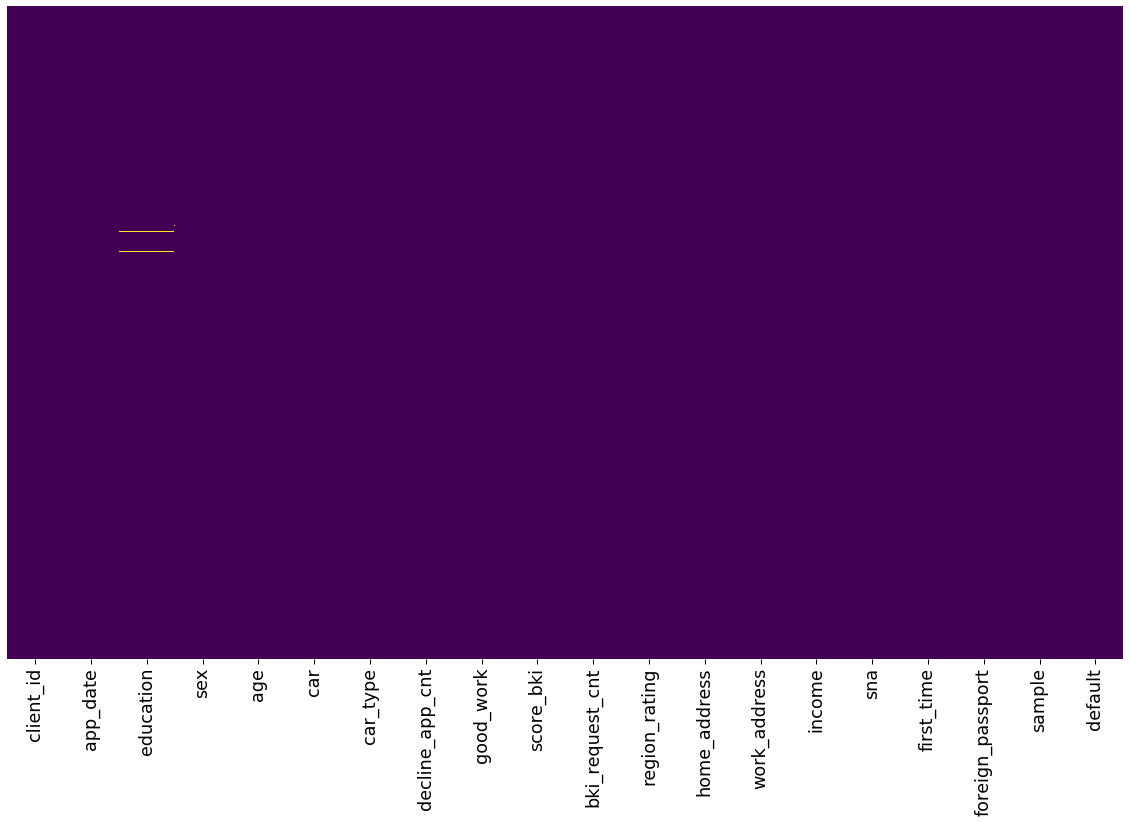

In [65]:
fig, ax = plt.subplots(figsize=(20, 12))
sns_heatmap = sns.heatmap(
    df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

В данных о клиентах присутствуют переменные всех типов, не все имеют числовую запись, а также есть пропущенные значения. Значит, нам необходима предварительная очистка данных. Пропуски имеются только в одном столбце 'education'.

Посмотрим на распределение признака default:

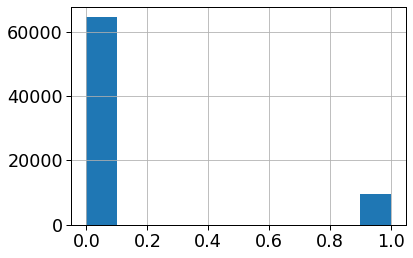

In [66]:
data_train.default.hist()

Недефолтных клиентов у банка значительно больше, чем дефолтных. Данные несбалансированны.

Сгруппируем признаки в три категории по типу их обработки (категориальные, бинарные и числовые):

In [67]:
# бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# категориальные переменные
cat_cols = ['education', 'work_address', 'home_address', 'sna', 'app_date']

# числовые переменные
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki', 'region_rating','first_time']

Смотрим распределение числовых признаков:

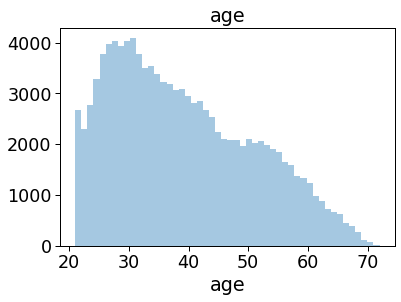

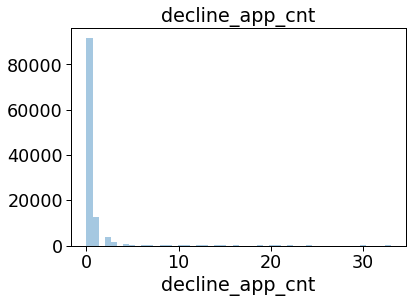

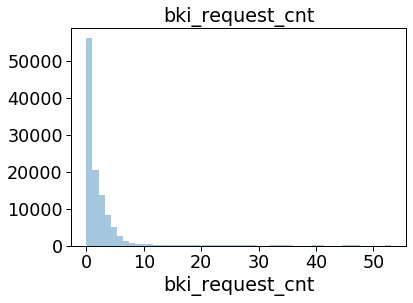

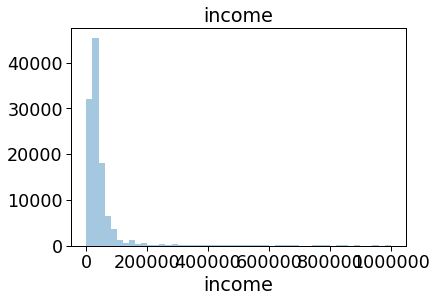

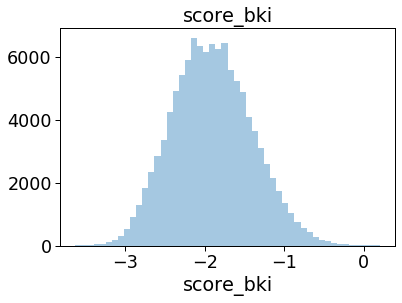

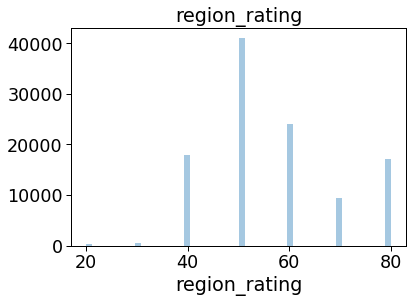

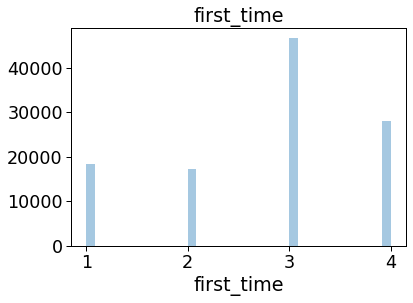

In [68]:
for i in num_cols:
    plt.figure()
    sns.distplot(df[i], kde=False, rug=False)
    plt.title(i)
    plt.show()

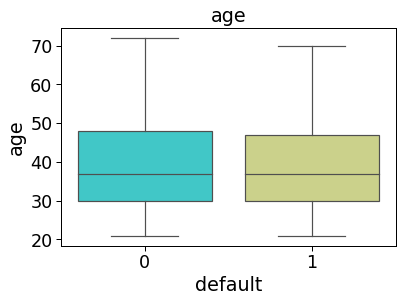

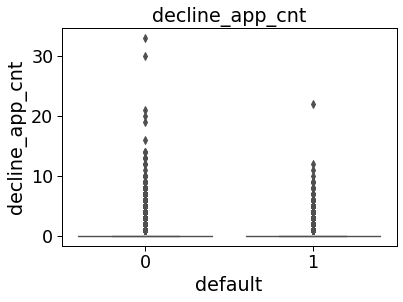

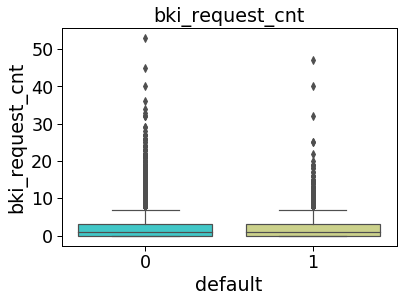

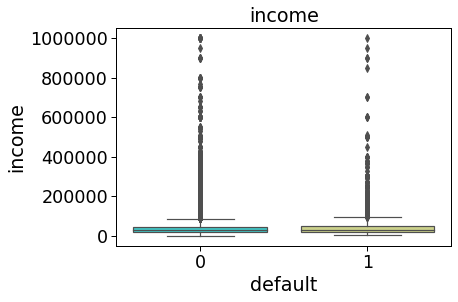

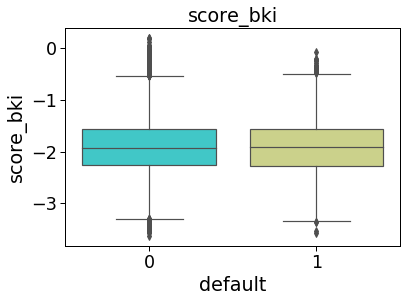

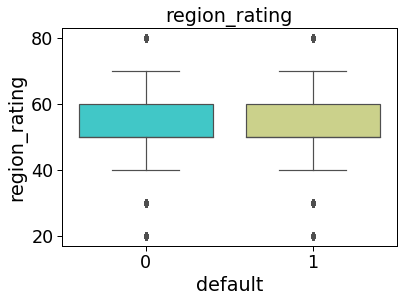

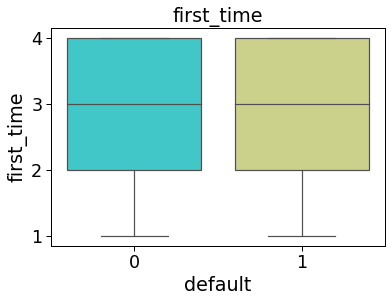

In [69]:
for i in num_cols:
    plt.figure()
    sns.boxplot(x = 'default', y = df[i], data = data_train,  palette='rainbow')
    plt.title(i)
    plt.show()

* Видим, что распределения всех чиловых признаков, кроме score_bki, имеют тяжелый правый хвост.
*  Дефолтные клиенты в среднем младше, имеют большее количество отклоненных заявок и больше запросов в БКИ,а также в среднем имеют более низкий доход.

Оценим корреляцию:

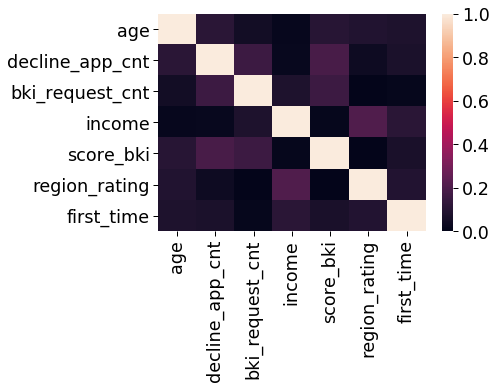

In [70]:
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1)

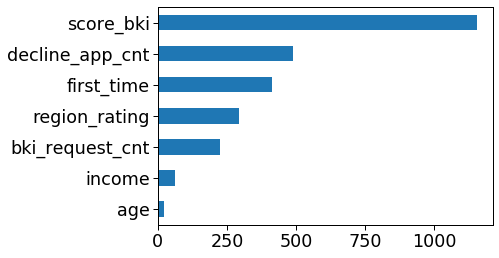

In [71]:
imp_num = pd.Series(f_classif(df[num_cols], df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Так как категориальные признаки требуют обработки, рассмотрим их подробнее в разделе 3.

# Построение наивной модели

Займемся преобразованием бинарных признаков:

In [72]:
label_encoder = LabelEncoder()
for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])

In [73]:
#удалим "education" из-за наличия пропусков
#удалим "app_date" и 'client_id'
df_naiv = df.drop(['client_id', 'education', 'app_date'], axis =1 )


In [74]:
train_processed = df_naiv.query('sample == 1').drop(['sample'], axis=1)
test_processed = df_naiv.query('sample == 0').drop(['sample'], axis=1)

In [75]:
# удалим для X целевую переменную и client_id
X = train_processed.drop(columns=['default'])
y = train_processed['default']


Model Type: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)



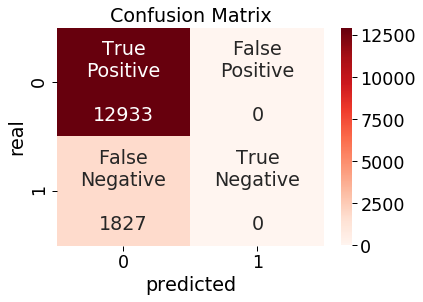


accuracy_score:		 0.876
f1_score:		 0.0
recall_score:		 0.0
precision_score:	 0.0
roc_auc_score:		 0.584



C:\Users\lll20\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [76]:
lr = LogisticRegression(random_state=RANDOM_SEED, max_iter=1000)
visualise_metrics(lr, X, y)

Наивная модель выдает кредит абсолютно всем. Однозначно, это не то, что нужно банку.

# EDA: визуализация, выбросы, пропуски, корреляционный анализ, генерация признаков

* education

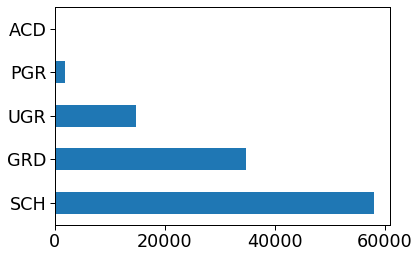

In [77]:
df.education.value_counts().plot.barh()

Заполним пропуски самым распространенным значением - "SCH":

In [78]:
df.education = df.education.fillna(df.education.mode()[0])
df.isnull().sum()

client_id           0
app_date            0
education           0
sex                 0
age                 0
car                 0
car_type            0
decline_app_cnt     0
good_work           0
score_bki           0
bki_request_cnt     0
region_rating       0
home_address        0
work_address        0
income              0
sna                 0
first_time          0
foreign_passport    0
sample              0
default             0
dtype: int64

In [79]:
# закодируем  признак 'education'
label_encoder = LabelEncoder()
df['education'] = label_encoder.fit_transform(df['education'])
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,1,1,29,1,1,0,0,-2.271884,3,50,1,2,50000,1,4,0,0,-1
1,17527,24JAN2014,3,0,39,0,0,5,0,-1.504999,2,50,1,2,5000,4,3,0,0,-1
2,75683,23MAR2014,4,1,50,1,1,0,0,-1.691339,1,50,1,2,30000,1,3,1,0,-1
3,26883,03FEB2014,3,1,56,0,0,0,0,-2.374182,1,40,1,2,17000,1,3,0,0,-1
4,28862,04FEB2014,1,0,38,0,0,0,0,-2.487502,0,80,2,3,120000,1,3,0,0,-1


* Так как распределения всех чиловых признаков, кроме score_bki, имеют тяжелый правый хвост. Прологарифмируем их,чтобы уйти от этой проблемы. score_bki исключим из логарифмировани, так как он может принимать отрицательные значения.

In [80]:
for i in num_cols:
    if i != 'score_bki':
        df[i] =  np.log(1 + df[i])

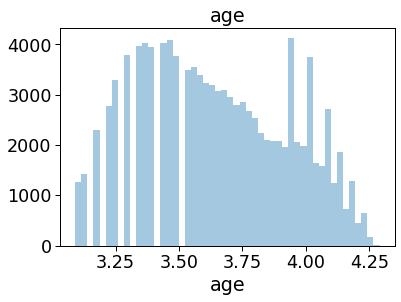

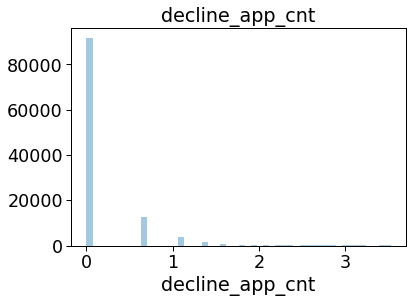

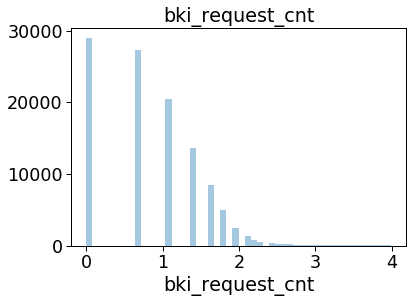

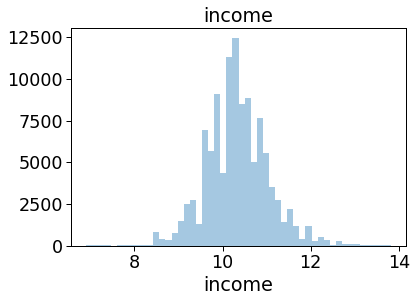

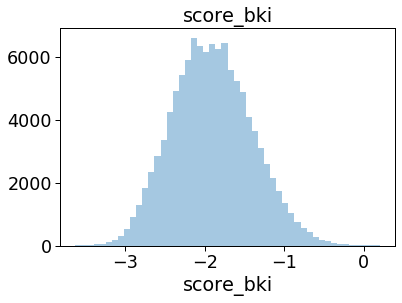

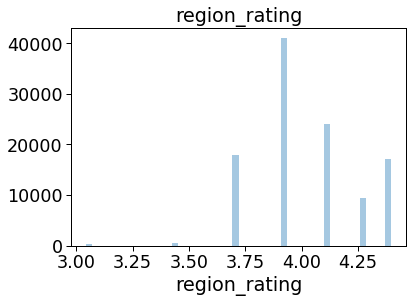

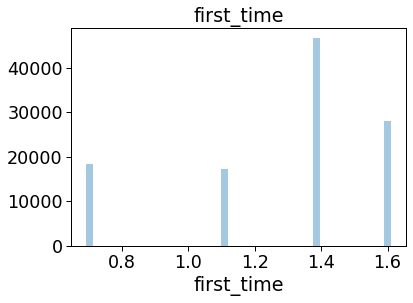

In [81]:
for i in num_cols:
    plt.figure()
    sns.distplot(df[i], kde=False, rug=False)
    plt.title(i)
    plt.show()

Сработало только с признаком income.

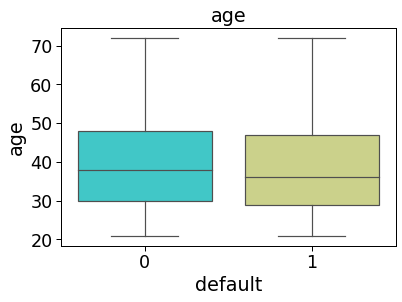

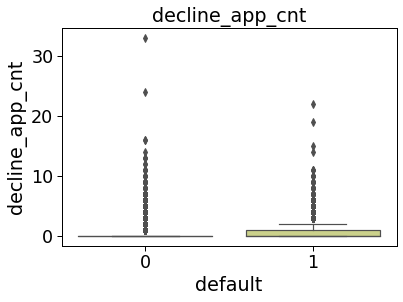

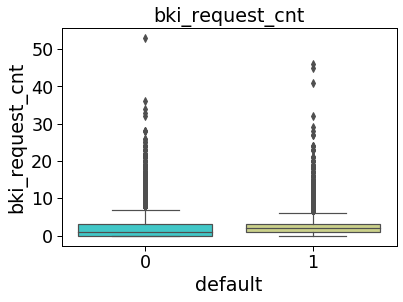

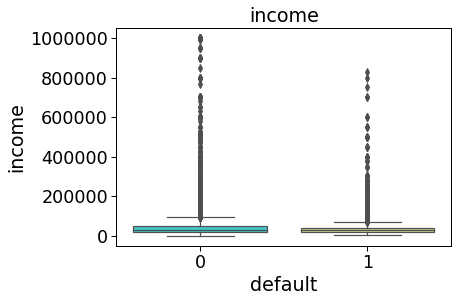

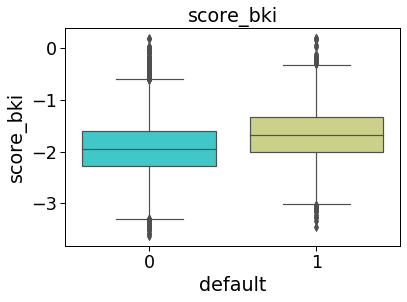

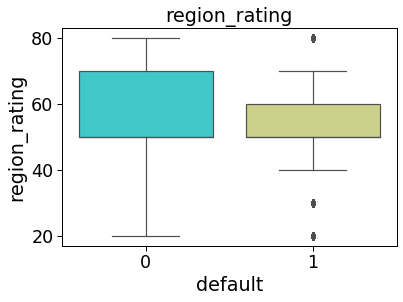

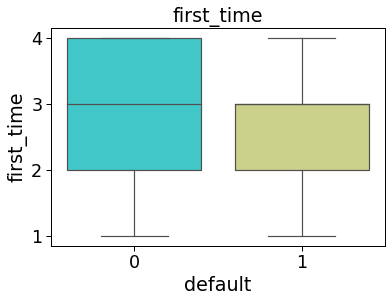

In [82]:
for i in num_cols:
    plt.figure()
    sns.boxplot(x = 'default', y = data_train[i], data = data_train,  palette='rainbow')
    plt.title(i)
    plt.show()

На боксплотах видно большое количество выбросов в score_bki, income и decline_app_cnt.

* app_date

In [83]:
df['app_date'] = pd.to_datetime(df['app_date'])
df['app_date'].dt.month.value_counts()

3    31597
2    27097
4    26266
1    25188
Name: app_date, dtype: int64

In [84]:
df['app_date'] = df['app_date'].apply(lambda x: x.month)

Данные предоставлены всего за 4 месяца. app_data в качестве категориального признака малоинформативен. Отбросим его:

In [85]:
'''df = df.drop(df[['app_date']], axis=1)
cat_cols = list(set(cat_cols) - set(['app_date'] + set(['app_month'])))'''

"df = df.drop(df[['app_date']], axis=1)\ncat_cols = list(set(cat_cols) - set(['app_date'] + set(['app_month'])))"

# Оценка важности

Оценим корреляцию и значимость числовых признаков:

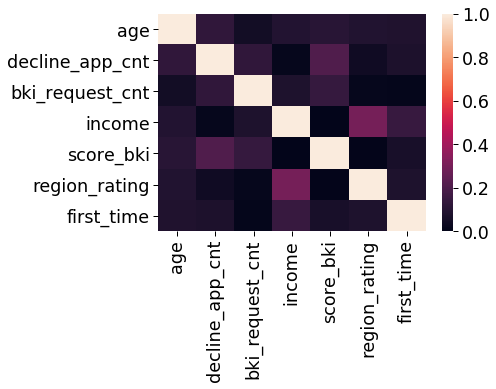

In [86]:
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1)

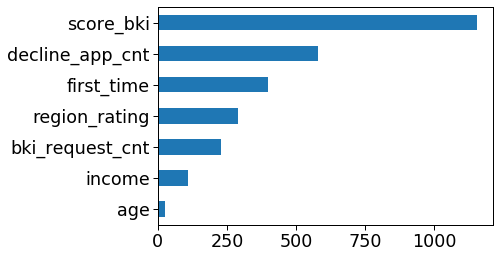

In [87]:
imp_num = pd.Series(f_classif(df[num_cols], df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Как мы видим, взаимосвязь пар числовых признаков по Пирсону слабая, что прекрасно для нашей модели! 
score_bki - наиболее значимый числовой признак, age - наименее значимый.

Оценим корреляцию и значимость категориальных признаков:

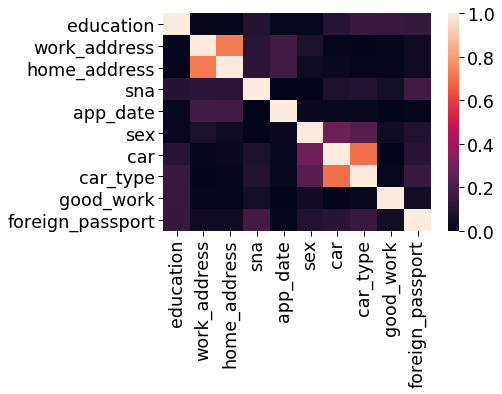

In [88]:
sns.heatmap(df[cat_cols + bin_cols].corr().abs(), vmin=0, vmax=1)

Наблюдается высокая корреляция между признаками home_addres/work_address, car/car_type. Посмотрим на значимость признаков и решим, какие отбросить, а какие оставить.

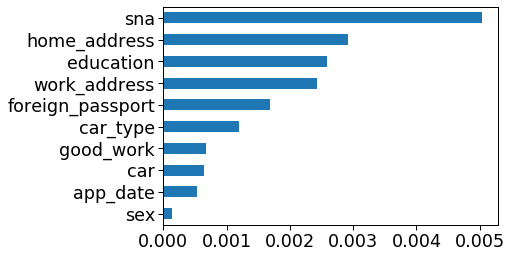

In [89]:
imp_cat = pd.Series(mutual_info_classif(df[bin_cols + cat_cols], df['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Согласно значимости оставляем - home_address и car_type, удаляем - work_address и car. 

In [90]:
df = df.drop(df[['work_address', 'car_type']], axis=1)
cat_cols = list(set(cat_cols) - set(['work_address']))
bin_cols = list(set(bin_cols) - set(['car_type']))

Перед обучением регрессии стандартизируем числовые признаки,а для категориальных переменных используем dummy-кодирование:

In [91]:
X_num = StandardScaler().fit_transform(df[num_cols].values)
df[num_cols]=X_num

In [92]:
df = pd.get_dummies(df, columns=cat_cols)
df.head()

,client_id,sex,age,car,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,income,...,home_address_3,sna_1,sna_2,sna_3,sna_4,education_0,education_1,education_2,education_3,education_4
0,74835,1,-0.888776,1,-0.418815,0,-0.735587,0.770563,-0.439531,0.680425,...,0,1,0,0,0,0,1,0,0,0
1,17527,0,0.120447,0,4.539989,0,0.800039,0.333797,-0.439531,-2.624624,...,0,0,0,0,1,0,0,0,1,0
2,75683,1,0.972731,1,-0.418815,0,0.426908,-0.281790,-0.439531,-0.052834,...,0,1,0,0,0,0,0,0,0,1
3,26883,1,1.362924,0,-0.418815,0,-0.940432,-0.281790,-1.408242,-0.868125,...,0,1,0,0,0,0,0,0,1,0
4,28862,0,0.031629,0,-0.418815,0,-1.167347,-1.334144,1.613807,1.937123,...,0,1,0,0,0,0,1,0,0,0


# Построение модели логистической регрессии


Model Type: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)



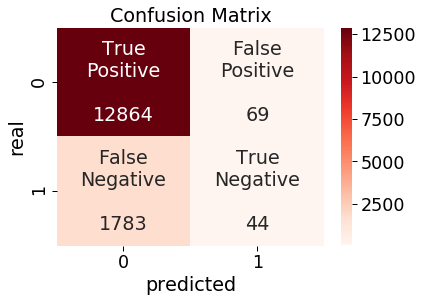


accuracy_score:		 0.875
f1_score:		 0.0454
recall_score:		 0.0241
precision_score:	 0.389
roc_auc_score:		 0.741



In [103]:
train_processed = df.query('sample == 1').drop(['sample', 'client_id'], axis=1)
test_processed = df.query('sample == 0').drop(['sample'], axis=1)

# удалим для X целевую переменную 
X = train_processed.drop(columns=['default'])
y = train_processed['default']

lr = LogisticRegression(random_state=RANDOM_SEED, max_iter=1000)
visualise_metrics(lr, X, y)

Предсказания модели улучшились, но всё еще неприменимы в реальной жизни. Улучшаем!

# Эксперименты


Model Type: LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)



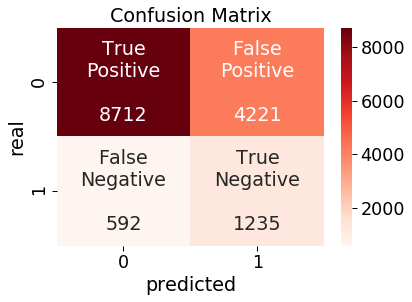


accuracy_score:		 0.674
f1_score:		 0.339
recall_score:		 0.676
precision_score:	 0.226
roc_auc_score:		 0.741



In [94]:
#Попробуем сбалансировать классы в модели
lr_balanced = LogisticRegression(
    class_weight='balanced', max_iter=1000, random_state=RANDOM_SEED)
visualise_metrics(lr_balanced, X, y)

В сбалансированной модели резко уменьшается количество ошибок первого рода, но появляется значительное количество ошибок второго рода.
В то же время, f1_score выше у class_weight=balanced.

# Подбор гиперпараметров

In [98]:
# создадим набор гиперпараметров
hyperparameters = {'C': np.logspace(-4, 4, 20)}

model = LogisticRegression(random_state=RANDOM_SEED,
                           class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)
# создадим сетку поиска с использованием 5-кратной перекрёстной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0, scoring='roc_auc')

best_model = clf.fit(X_train, y_train)

# вывод лучшего параметра С
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее C: 0.012742749857031334



Model Type: LogisticRegression(C=0.012742749857031334, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)



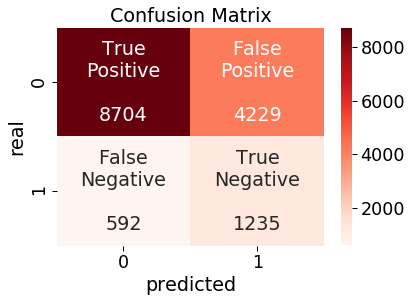


accuracy_score:		 0.673
f1_score:		 0.339
recall_score:		 0.676
precision_score:	 0.226
roc_auc_score:		 0.741



In [99]:
lr_best = LogisticRegression(
    random_state=RANDOM_SEED, class_weight='balanced', max_iter=1000, C=0.012742749857031334)
visualise_metrics(lr_best, X, y)

In [105]:
X_test = test_processed.drop(columns=['default', 'client_id'])
y_pred = lr_best.predict_proba(X_test)
results_df = pd.DataFrame(data={'client_id':test_processed['client_id'], 'default':y_pred[:,1]})
results_df.to_csv('submission.csv', index=False)
results_df

,client_id,default
0,74835,0.255537
1,17527,0.786541
2,75683,0.337744
3,26883,0.395531
4,28862,0.144245
...,...,...
36344,83775,0.806325
36345,106254,0.109476
36346,81852,0.771487
36347,1971,0.661723
